# London Boulevard

Jack Carter - 12/04/2023

The demise of Colin Farrell's character in London Boulevard reminds us that crime can always get in the way of our plans. But how should we account for things like saftey in light of other factors when looking for somewhere to live? This project models data from the [Greater London Authority (GLA)](https://data.london.gov.uk/dataset/mylondon) to find the best neighbourhoods in London based on the user's relative importance given to rent, green space, travel and saftey.

## Parameters

In [1]:
# sets how important these factors are for the user (with 1 as the average). 
rent = 1.5
green_space = 1.5
travel = 0.5
safety = 0.5

## Read-in data

In [2]:
# imports libraries
import pandas as pd
import numpy as np

# reads in the MyLondon summary dataset of the Greater London Authority (GLA)
initial_data = pd.read_csv('C:/Users/HUAWEI/Desktop/Projects/London-Boulevard/Data/summary.csv')

# re-orders the data based on area name
data = initial_data.sort_values('LAD').reset_index(drop=True)
data.Rent_per_m = data.Rent_per_m*-1 # makes rent negative as higher rents are bad

## Average columns by area

In [3]:
# returns the averages for each LAD area of a given column
def get_col_avgs(dataframe, identifier, col):
    data = dataframe
    unique_area = data[identifier].unique()
    area_averages = []
    for i in range(len(unique_area)):
        temp_data = data[data[identifier] == unique_area[i]].reset_index(drop=True)
        total = []
        for dat in range(len(temp_data)):
            total.append(temp_data.loc[dat, col])
        area_averages.append(round(sum(total)/len(temp_data),2))
    return area_averages

desired_cols = ['Rent_per_m', 'green_spac', 'travel', 'safety']

def get_avg_df(df, identifier):
    cols = []
    for i in range(len(desired_cols)):
        cols.append(get_col_avgs(df, identifier, desired_cols[i]))

    dataframe = pd.DataFrame({'Area': data[identifier].unique(), 'Rent_per_m':cols[0], 'green_spac':cols[1], 'travel':cols[2], 'safety':cols[3]})
    return dataframe

macro_df = get_avg_df(data, 'LAD')
medium_df = get_avg_df(data, 'LSOA')
fine_df = data.drop('schools', axis=1)

## Z-score normalization

In [4]:
# uses z-score normalization to make the data comparable 
def normalize(col):
    avg = np.mean(col)
    sd = np.std(col)
    z_scores = []
    for i in range(len(col)):
        z_scores.append( (col[i]-avg)/sd )
    return z_scores

def normalize_cols(df):
    for i in range(len(desired_cols)):
        df[desired_cols[i]] = normalize(df[desired_cols[i]])
    
normalize_cols(macro_df)
normalize_cols(medium_df)
normalize_cols(fine_df)

## Column weighting

In [5]:
# weights the results to account for what the user thinks is most important
weights = [rent, green_space, travel, safety]

def weight_results(df):
    for i in range(len(desired_cols)):
        df[desired_cols[i]] = df[desired_cols[i]]*weights[i]
        
weight_results(macro_df)
weight_results(medium_df)
weight_results(fine_df)

## Create a total column

In [6]:
# Calculates a total across all 
def calculate_row_total(data, start_row):
    total = []
    for i in range(len(data)):
        row = data.loc[i,:]
        total.append(sum(row[start_row:len(row)]))
    return total
        
macro_df_total = pd.DataFrame({'Area': macro_df['Area'], 'Rent': macro_df['Rent_per_m'], 'Green': macro_df['green_spac'], 'Travel': macro_df['travel'], 'Safety': macro_df['safety'], 'Total': calculate_row_total(macro_df, 1)})
medium_df_total = pd.DataFrame({'Area': medium_df['Area'], 'Rent': medium_df['Rent_per_m'], 'Green': medium_df['green_spac'], 'Travel': medium_df['travel'], 'Safety': medium_df['safety'], 'Total': calculate_row_total(medium_df, 1)})
fine_df_total = pd.DataFrame({'Area': fine_df['OA'], 'Rent': fine_df['Rent_per_m'], 'Green': fine_df['green_spac'], 'Travel': fine_df['travel'], 'Safety': fine_df['safety'], 'Total': calculate_row_total(fine_df, 3)})

## Join geospatial data

In [7]:
# imports libraries and joins geospatial data and totals data
import geopandas
import matplotlib.pyplot as plt

# defines a path to read in geospatial data
macro_path = 'C:/Users/HUAWEI/Desktop/Projects/London-Boulevard/Data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp'
medium_path = 'C:/Users/HUAWEI/Desktop/Projects/London-Boulevard/Data/statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp'
fine_path = 'C:/Users/HUAWEI/Desktop/Projects/London-Boulevard/Data/statistical-gis-boundaries-london/ESRI/OA_2011_London_gen_MHW.shp'

# reads in geospatial data
macro_map_df = geopandas.read_file(macro_path)
medium_map_df = geopandas.read_file(medium_path)
fine_map_df = geopandas.read_file(fine_path)

# sorts geospatial data values 
macro_map_df.sort_values('NAME').reset_index(drop=True)
medium_map_df.sort_values('LSOA11CD').reset_index(drop=True)
fine_map_df.sort_values('OA11CD').reset_index(drop=True)

# sorts totals data values 
macro_df_total = macro_df_total.sort_values('Area')
medium_df_total = medium_df_total.sort_values('Area').reset_index(drop=True)
fine_df_total = fine_df_total.sort_values('Area').reset_index(drop=True)

# merges the geospatial and totals dataframes
macro_merged_df = macro_map_df.set_index('NAME').join(macro_df_total.set_index('Area'))
medium_merged_df = medium_map_df.set_index('LSOA11CD').join(medium_df_total.set_index('Area'))
fine_merged_df = fine_map_df.set_index('OA11CD').join(fine_df_total.set_index('Area'))

## Plot London by map

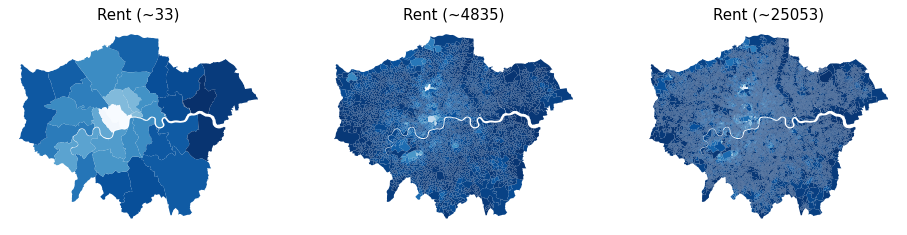

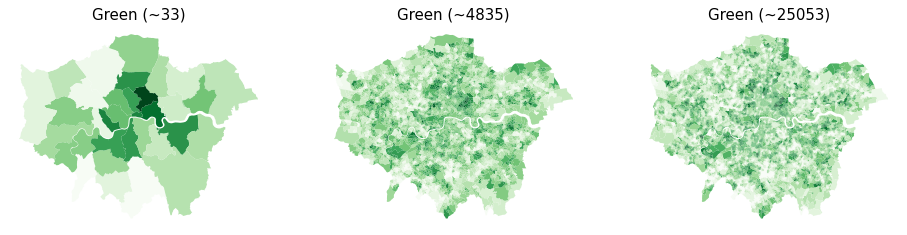

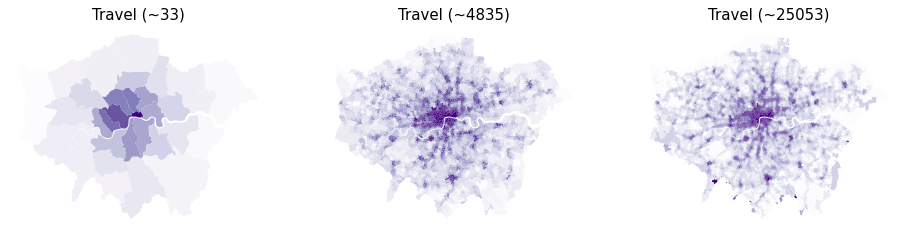

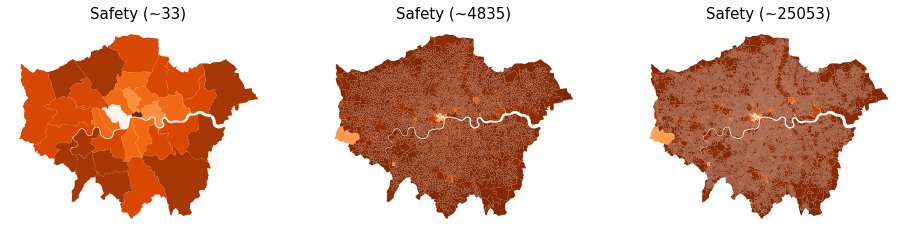

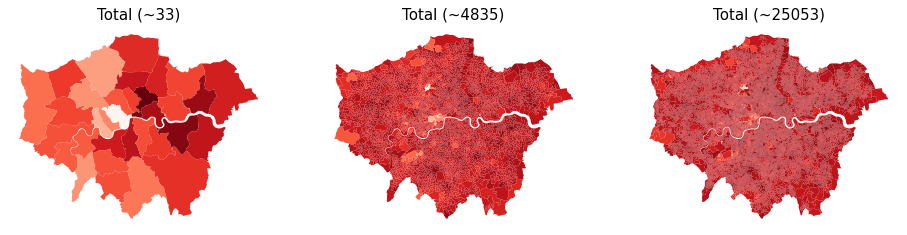

In [8]:
# gets multiple plots for london
def get_boroughs_plot(target_var, color):
    vmin, vmax = 0, 100
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 12))

    macro_merged_df.plot(column=target_var, cmap=color, linewidth=0.8, ax=ax[0]);
    ax[0].set_title(target_var + ' (~' + str(len(macro_merged_df)) + ')', fontsize=15)
    ax[0].axis('off');
    
    medium_merged_df.plot(column=target_var, cmap=color, linewidth=0.8, ax=ax[1]);
    ax[1].set_title(target_var + ' (~' + str(len(medium_merged_df)) + ')', fontsize=15)
    ax[1].axis('off');
    
    fine_merged_df.plot(column=target_var, cmap=color, linewidth=0.8, ax=ax[2]);
    ax[2].set_title(target_var + ' (~' + str(len(fine_merged_df)) + ')', fontsize=15)
    ax[2].axis('off');

column = ['Rent', 'Green', 'Travel', 'Safety', 'Total']
colors = ['Blues', 'Greens', 'Purples', 'Oranges', 'Reds']

for i in range(len(column)):
    get_boroughs_plot(column[i], colors[i])

## List top 10 boroughs

In [9]:
macro_df_total.sort_values('Total', ascending=False).head(10).loc[:,['Area','Total']]

,Area,Total
11,Hackney,3.072786
6,City of London,2.800044
10,Greenwich,2.601146
0,Barking and Dagenham,2.253851
29,Tower Hamlets,1.975260
21,Lambeth,1.541491
2,Bexley,1.377194
13,Haringey,1.247106
31,Wandsworth,0.978786
15,Havering,0.894759


## Plot best borough by map

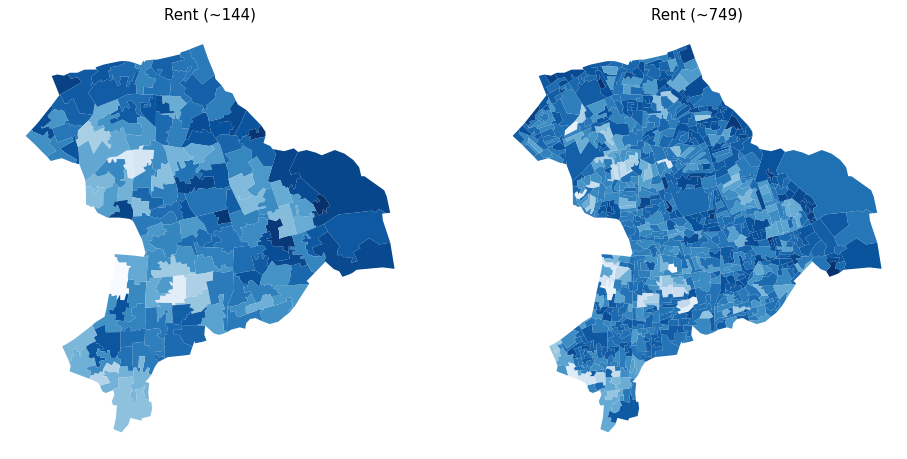

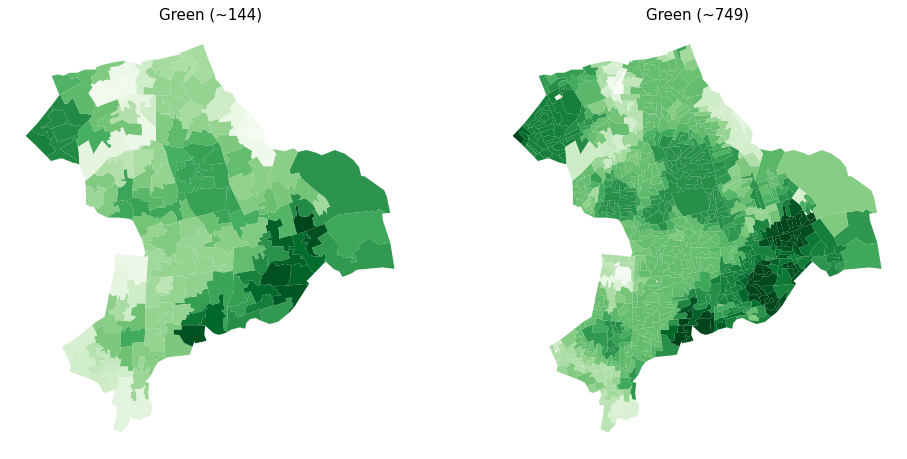

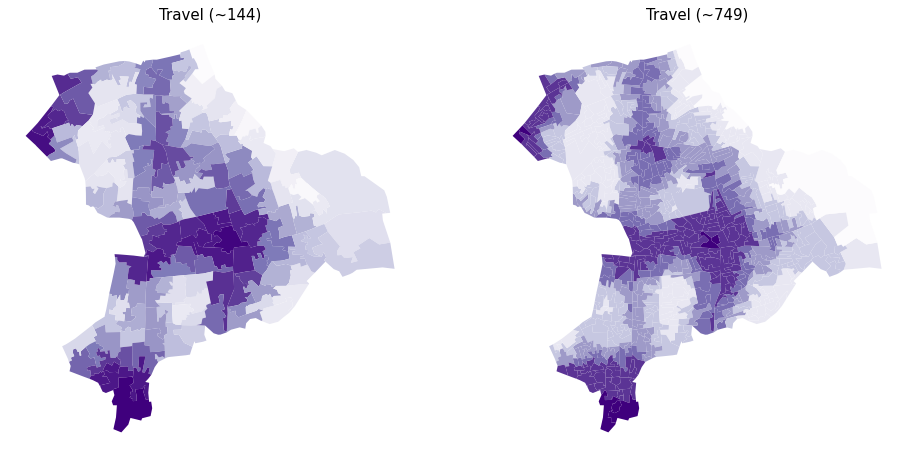

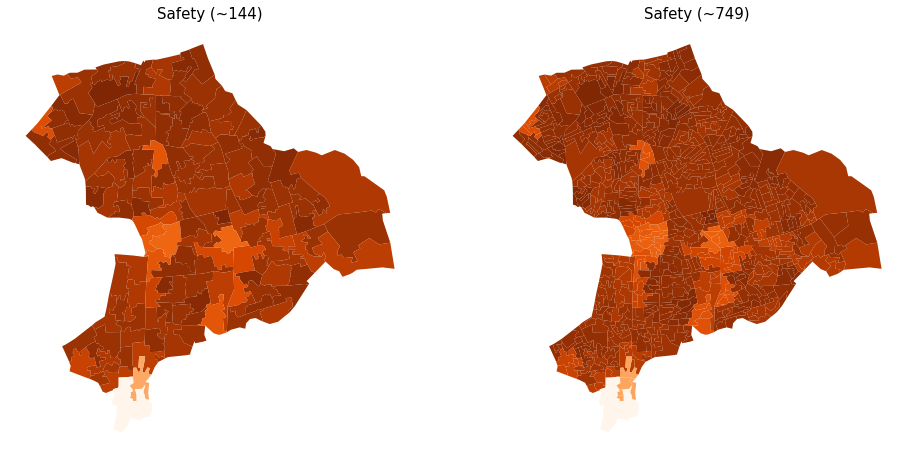

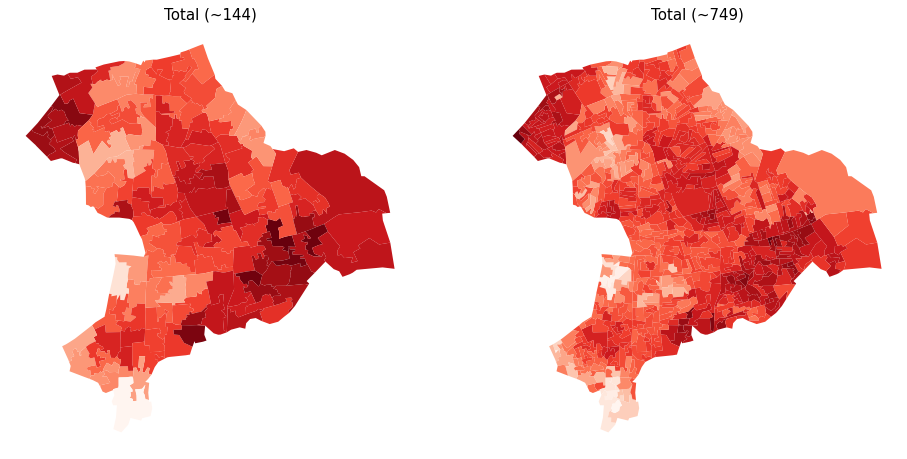

In [10]:
# gets the best borough
best_borough = macro_df_total.sort_values('Total', ascending=False).head(10).loc[:,'Area',].reset_index(drop=True)[0]

# filters the medium and fine dfs to include only the best borough
medium_merged_df = medium_merged_df[medium_merged_df.LAD11NM==best_borough]
fine_merged_df = fine_merged_df[fine_merged_df.LAD11NM==best_borough]

# gets multiple plots
def get_neighbourhoods_plot(target_var, color):
    vmin, vmax = 0, 100
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
    
    medium_merged_df.plot(column=target_var, cmap=color, linewidth=0.8, ax=ax[0]);
    ax[0].set_title(target_var + ' (~' + str(len(medium_merged_df)) + ')', fontsize=15)
    ax[0].axis('off');
    
    fine_merged_df.plot(column=target_var, cmap=color, linewidth=0.8, ax=ax[1]);
    ax[1].set_title(target_var + ' (~' + str(len(fine_merged_df)) + ')', fontsize=15)
    ax[1].axis('off');

column = ['Rent', 'Green', 'Travel', 'Safety', 'Total']
colors = ['Blues', 'Greens', 'Purples', 'Oranges', 'Reds']

for i in range(len(column)):
    get_neighbourhoods_plot(column[i], colors[i])

## List best borough's top 10 neighbourhoods

In [11]:
# finds the top 10 neighbourhood in the top borough
dat = fine_merged_df.sort_values('Total', ascending=False).loc[:,['WD11NM_BF','Total']]
unique = dat['WD11NM_BF'].unique()

totals = []
for i in range(len(unique)):
    temp_df = dat.loc[dat.WD11NM_BF==unique[i]]
    totals.append(sum(temp_df.Total)/len(temp_df))
    
neighbourhood_df = pd.DataFrame({'Neighbourhood':unique, 'Total':totals})
neighbourhood_df.sort_values('Total', ascending=False).head(10)

,Neighbourhood,Total
5,Wick,3.588232
0,Brownswood,3.547429
3,Victoria,3.036800
1,Chatham,2.940926
9,Hackney Downs,2.764501
4,King's Park,2.183418
7,Hackney Central,2.026603
14,Cazenove,1.880065
8,Dalston,1.258797
15,Stoke Newington Central,1.258404
